In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn import preprocessing
from scipy import stats
import csv
import os
import sys
import logging
from keras.layers import LSTM
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import dill

# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# # Keras outputs warnings using `print` to stderr so let's direct that to devnull temporarily
# stderr = sys.stderr
# sys.stderr = open(os.devnull, 'w')

# import keras

# # we're done
# sys.stderr = stderr

# from keras.backend.tensorflow_backend import tf

# import absl.logging
# logging.root.removeHandler(absl.logging._absl_handler)
# absl.logging._warn_preinit_stderr = False

# logger = tf.get_logger()
# logger.setLevel(logging.FATAL)

# graph = tf.get_default_graph()


Using TensorFlow backend.
/Users/nn2tf/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/nn2tf/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/nn2tf/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/nn2tf/anaconda3/lib/python3.7/site-packages/tenso

In [2]:
path = '/Volumes/GoogleDrive/My Drive/Research/Bloom Forecasting/Multivariate/NN-multi/Peter_nor/lstm_ende-2/'

In [3]:
dataset = read_csv('ExperimentalLakes_Data_withColorNormalizedCumulativePloading.csv', header=0, index_col=3, parse_dates=True, squeeze=False)

In [4]:
def data_prep_multi(dataset, lake):
    ex=dataset[dataset.lake==lake]
    ex = ex.dropna(subset=["chl"])
    ex.zmix_hf = ex.zmix_hf.fillna(ex.zmix_daily)
    ex.temp_zmix_hf = ex.temp_zmix_hf.fillna(ex.temp_zmix_daily) 
    ex = ex.interpolate()
    #ex = ex.drop(["lake",'zmix_daily','temp_zmix_daily', 'windDir_mean', 'dosat','doy','temp_Sonde','airTemp_mean','WindGust_mean','N_mg_m2_day','pH','DOconc','Zmix_hfAve','PAR_mean','windspd_mean' ], axis=1)
    #ex["cum_p"]=ex.groupby(['year'])['p_loading'].cumsum(axis=0)
    cols =  ['chl']+['temp_zmix_hf']+['p_cumul_over_color'] +['year']+['doy']
    ex = ex[cols]    
    return ex

In [5]:
ex_R_multi= data_prep_multi(dataset, "R")
#ex_R_multi=ex_R_multi[:-2]

In [6]:
#ex_R_multi['chl'] = (ex_R_multi['chl'] - ex_R_multi['chl'].min()) / (ex_R_multi['chl'].max() - ex_R_multi['chl'].min()) *100
#ex_R_multi['temp_zmix_hf'] = (ex_R_multi['temp_zmix_hf'] - ex_R_multi['temp_zmix_hf'].min()) / (ex_R_multi['temp_zmix_hf'].max() - ex_R_multi['temp_zmix_hf'].min()) *100
#ex_R_multi['p_cumul_over_color'] = (ex_R_multi['p_cumul_over_color'] - ex_R_multi['p_cumul_over_color'].min()) / (ex_R_multi['p_cumul_over_color'].max() - ex_R_multi['p_cumul_over_color'].min()) *100

In [7]:
ex_R_multi.head()

,chl,temp_zmix_hf,p_cumul_over_color,year,doy
date,,,,,
2008-05-15,8.08505,13.970398,0.0,2008,136
2008-05-16,14.42403,15.116002,0.0,2008,137
2008-05-17,11.80493,14.782927,0.0,2008,138
2008-05-18,11.74800,13.788608,0.0,2008,139
2008-05-19,11.99472,13.556983,0.0,2008,140


In [8]:
years= sorted(list(set(ex_R_multi['year'])))

In [9]:
train1= np.array(ex_R_multi.loc[ex_R_multi['year'] < 2015])
train1 = train1.reshape(train1.shape[0],1, train1.shape[1])
valid= np.array(ex_R_multi[ex_R_multi['year']==2015])
valid = valid.reshape(valid.shape[0], 1, valid.shape[1])
train2= np.array(ex_R_multi.loc[ex_R_multi['year'] < 2019])
train2 = train2.reshape(train2.shape[0],1, train2.shape[1])
test= np.array(ex_R_multi[ex_R_multi['year']==years[-1]])
test = test.reshape(test.shape[0], 1, test.shape[1])
print(len(ex_R_multi),len(train1), len(train2), len(valid), len(test))

932 630 816 102 116


### LSTM Encoder Decoder Model

In [10]:
# convert array into sequences of inputs and outputs
def to_supervised_lstmende(train, n_input, n_out=7):
    # flatten data
    #data = data.reshape((data.shape[0]*data.shape[1]))
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            X.append(data[in_start:in_end, :-2])
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)

In [11]:
train_x, train_y = to_supervised_lstmende (train2, 7)

In [151]:
train_x.shape

(803, 7, 3)

In [152]:
train_x[0]

array([[ 8.08505   , 13.97039768,  0.        ],
       [14.42403   , 15.11600158,  0.        ],
       [11.80493   , 14.78292681,  0.        ],
       [11.748     , 13.78860757,  0.        ],
       [11.99472   , 13.55698258,  0.        ],
       [13.41815   , 13.83088509,  0.        ],
       [10.5713    , 14.12516788,  0.        ]])

In [173]:
# train the model
def build_model_lstmende(train, config):
    # define parameters
    n_input, n_nodes, n_epochs, n_batch = config
    # prepare data
    train_x, train_y = to_supervised_lstmende(train, n_input)
    #train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    n_features, n_outputs = train_x.shape[2], train_y.shape[1]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(n_nodes, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

In [174]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [175]:
#final evaluation
def final_eval_lstmende (train, test, config):
    #train_array = np.array(train['chl'])
    #test_array = np.array(test['chl'])
    #train_array= train_array.reshape(-1, 1)
    #test_array= test_array.reshape(-1, 1)
    model= build_model_lstmende(train, config)
    test_x, test_y = to_supervised_lstmende(test, config[0])
    predictions = model.predict(test_x)
    score, scores= evaluate_forecasts(test_y, predictions)
    return score, scores, predictions 

In [199]:
# create a list of configs to try
def model_configs_lstmende():
    # define scope of configs
    n_input = [5,7,9]
    n_nodes = [200, 400]
    n_epochs = [20, 50]
    n_batch = [4, 16]
    # create configs
    configs = list()
    for i in n_input:
        for j in n_nodes:
            for k in n_epochs:
                for l in n_batch:
                    cfg = [i, j, k, l]
                    configs.append(cfg)
    print('Total configs: %d' % len(configs))
    return configs

In [200]:
cfig_list = model_configs_lstmende()

Total configs: 24


In [201]:
cfig_list

[[5, 200, 20, 4],
 [5, 200, 20, 16],
 [5, 200, 50, 4],
 [5, 200, 50, 16],
 [5, 400, 20, 4],
 [5, 400, 20, 16],
 [5, 400, 50, 4],
 [5, 400, 50, 16],
 [7, 200, 20, 4],
 [7, 200, 20, 16],
 [7, 200, 50, 4],
 [7, 200, 50, 16],
 [7, 400, 20, 4],
 [7, 400, 20, 16],
 [7, 400, 50, 4],
 [7, 400, 50, 16],
 [9, 200, 20, 4],
 [9, 200, 20, 16],
 [9, 200, 50, 4],
 [9, 200, 50, 16],
 [9, 400, 20, 4],
 [9, 400, 20, 16],
 [9, 400, 50, 4],
 [9, 400, 50, 16]]

In [202]:
#lstmende_result = dill.load(open('lstmende_result_pet.pkd', 'rb'))

In [203]:
#lstmende_result = dill.load(open('lstmende_result_pet.pkd', 'rb'))

In [ ]:
# from numpy.random import seed
# seed(1)
# import tensorflow as tf
# tf.keras.utils.set_random_seed(300)

rep = 50
lstmende_test_scores= []
iter= 1
for config in cfig_list:
    print(iter)
    test_scores_config = []
    for _ in range (rep):
        print(_)
    # final evaluate configs
        test_scores_config.append(final_eval_lstmende(train2, test, config))
    lstmende_test_scores.append (test_scores_config)
    iter+=1

#mlp_test = dill.load(open('mlp_test.pkd', 'rb'))

1
0
(816, 5)
(116, 5)
4/4 [==============================] - 0s 4ms/step
1
(816, 5)
(116, 5)
4/4 [==============================] - 0s 4ms/step
2
(816, 5)
(116, 5)
4/4 [==============================] - 0s 4ms/step
3
(816, 5)
(116, 5)
4/4 [==============================] - 0s 4ms/step
4
(816, 5)
(116, 5)
4/4 [==============================] - 0s 4ms/step
5
(816, 5)
(116, 5)
4/4 [==============================] - 0s 4ms/step
6
(816, 5)
(116, 5)
4/4 [==============================] - 0s 4ms/step
7
(816, 5)
(116, 5)
4/4 [==============================] - 0s 4ms/step
8
(816, 5)
(116, 5)
4/4 [==============================] - 0s 4ms/step
9
(816, 5)
(116, 5)
4/4 [==============================] - 0s 4ms/step
10
(816, 5)
(116, 5)
4/4 [==============================] - 0s 4ms/step
11
(816, 5)
(116, 5)
4/4 [==============================] - 0s 4ms/step
12
(816, 5)
(116, 5)
4/4 [==============================] - 0s 4ms/step
13
(816, 5)
(116, 5)
4/4 [==============================] - 0s 4ms/step


In [182]:
#dill.dump(lstmende_test_scores, open('lstmende_test_scores_pet_16-50.pkd', 'wb'))

In [13]:
lstmende_test_scores = dill.load(open('lstmende_test_scores_pet_16-50.pkd', 'rb'))

In [15]:
rep = 50
all_scores = []
for i in range(len(lstmende_test_scores)):
    config_scores = []
    for j in range (rep):
        overall = lstmende_test_scores[i][j][0]
        scores = lstmende_test_scores[i][j][1]
        config_scores.append([overall, scores])
    all_scores.append (config_scores)

In [16]:
overall_means = []
for i in range (len(all_scores)):
    Overall_scores= [all_scores[i][j][0] for j in range (rep)]
    overall_means.append(np.mean(Overall_scores))
min_overall = np.min(overall_means)
min_overall_index= overall_means.index(min_overall)
print ("Min average over all days=", min_overall, "The config with Min average=", min_overall_index)

Min average over all days= 5.939329071502632 The config with Min average= 9


In [18]:
seven_means = []
for i in range (len(all_scores)):
    sevenl_scores= [all_scores[i][j][1][6] for j in range (rep)]
    seven_means.append(np.mean(sevenl_scores))
min_7 = np.min(seven_means)
min_7_index= seven_means.index(min_7)
print ("Min 7 days (averages over iterations) over all config=", min_7, "The config with Min 7 days (averages over iterations) =", min_7_index)

Min 7 days (averages over iterations) over all config= 7.199726756200914 The config with Min 7 days (averages over iterations) = 9


In [19]:
overalls= []
for i in range (len(all_scores)):
    Overall_scores= [all_scores[i][j][0] for j in range (rep)]
    overalls.append (Overall_scores)

In [20]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


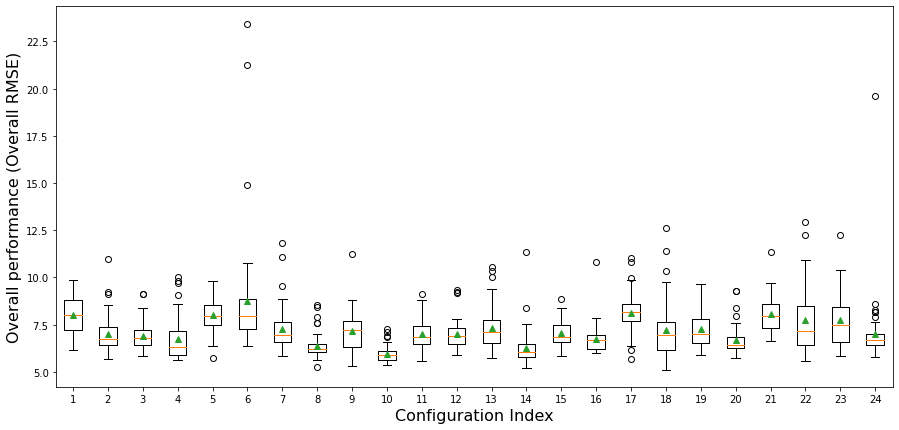

In [21]:

fig = plt.figure(figsize =(15, 7))
 
# Creating axes instance
#ax = fig.add_axes([0, 0, 1, 1])
ax= plt.axes()

ax.set_xlabel('Configuration Index', fontsize=16)
ax.set_ylabel('Overall performance (Overall RMSE)', fontsize=16)
ax.boxplot(overalls, showmeans = True)
# Creating plot

# show plot
plt.show()

In [22]:
sevendays = []
for i in range(len(lstmende_test_scores)):
    sevendays.append ([all_scores[i][j][1][6] for j in range (rep)])

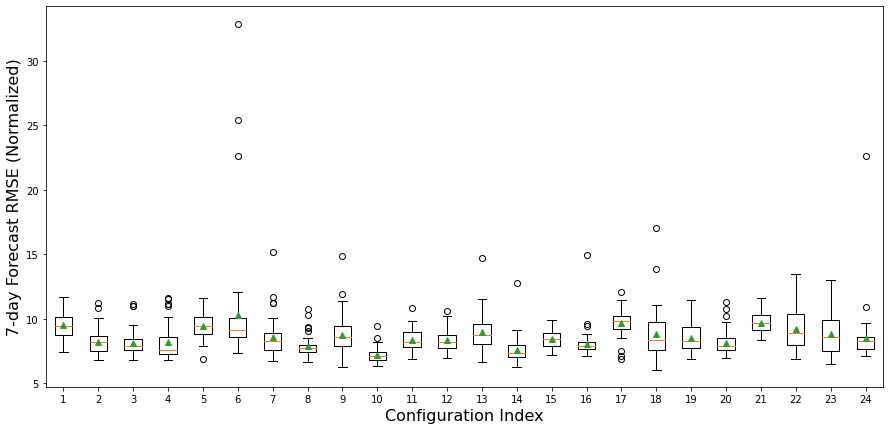

In [23]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize =(15, 7))
 
# Creating axes instance
#ax = fig.add_axes([0, 0, 1, 1])
ax= plt.axes()
ax.set_xlabel('Configuration Index', fontsize=16)
ax.set_ylabel('7-day Forecast RMSE (Normalized)', fontsize=16)
ax.boxplot(sevendays, showmeans = True)
# Creating plot

# show plot
plt.show()

In [24]:
all_days_best = []
for i in range(7):
    all_days_best.append ([all_scores[min_overall_index][j][1][i] for j in range (rep)])

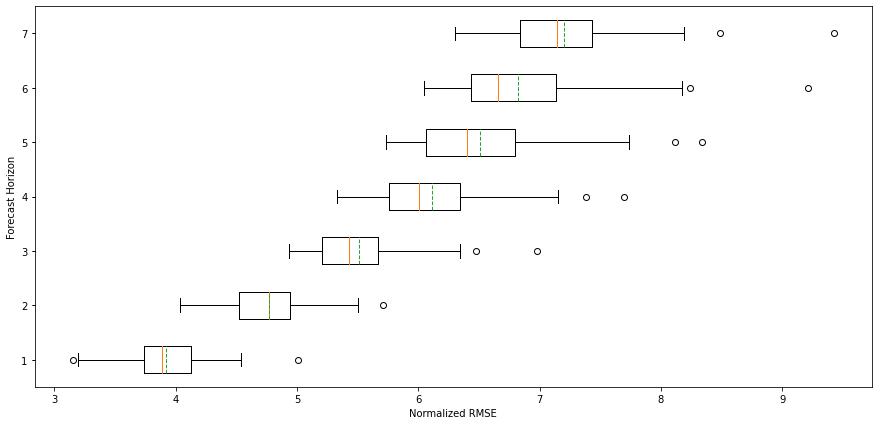

In [25]:

fig = plt.figure(figsize =(15, 7))
 
# Creating axes instance
#ax = fig.add_axes([0, 0, 1, 1])
ax= plt.axes()
ax.set (xlabel= 'Normalized RMSE', ylabel= 'Forecast Horizon', yticks= [1,2,3,4,5,6,7] )
ax.boxplot(all_days_best, vert= False, showmeans = True, meanline= True, manage_ticks= True)
positions = np.arange(36) + 1
#ax.plot(positions, seven_means, 'rs')
# Creating plot
#plt.rcParams['font.size'] = '16'
# show plot
plt.show()

In [26]:
predictions = np.array([lstmende_test_scores[min_overall_index][i][2] for i in range (rep)])
mean_predict = []
var_predict = []
for i in [0,3,6]:
    mean_predict_day= []
    var_predict_day= []
    for j in range(predictions.shape[1]):
        mean_predict_day.append(np.mean(predictions[:,j,i]))
        var_predict_day.append(np.std(predictions[:,j,i]))
    mean_predict.append(mean_predict_day)
    var_predict.append(var_predict_day)
    
    

In [27]:
len(mean_predict[0])

103

In [28]:
#np.array[np.mean(predictions[:, 6] for i in range (predictions.shape[1]))]

In [29]:
test2= ex_R_multi[ex_R_multi['year']==years[-1]]
y= np.array(test2['chl'])
x = np.array(test2.doy)


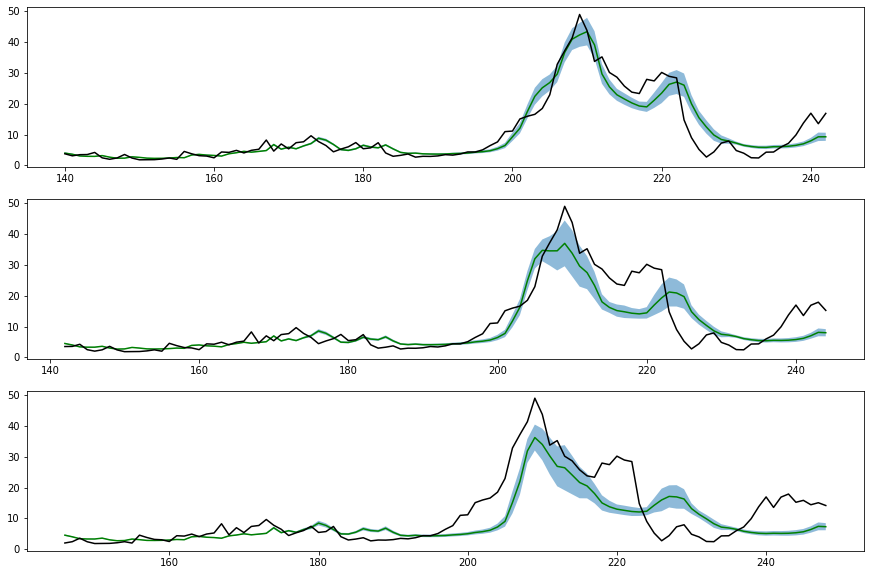

In [30]:
#plt.style.use('_mpl-gallery')

# plot
fig, ax = plt.subplots(3, figsize =(15, 10))
horizons= [1,3,7]
for i in range(3):
    z= np.array(mean_predict[i])
    z1= mean_predict[i] - np.array(var_predict[i])
    z2= mean_predict[i] + np.array(var_predict[i])
    start = len(test2)- len(z) -7+horizons[i]
    end= start+len(z)
    ax[i].fill_between(x[start:end], z1, z2, alpha=.5, linewidth=0)
    ax[i].plot(x[start: end], z, linewidth=1.5, color= 'green')
    ax[i].plot(x[start:end], y[start:end], linewidth=1.5, color= 'black');

In [31]:
predictions = np.array([lstmende_test_scores[min_overall_index][i][2] for i in range (rep)])
mean_predict = []
var_predict = []
for i in range(7):
    mean_predict_day= []
    var_predict_day= []
    for j in range(predictions.shape[1]):
        mean_predict_day.append(np.mean(predictions[:,j,i]))
        var_predict_day.append(np.std(predictions[:,j,i]))
    mean_predict.append(mean_predict_day)
    var_predict.append(var_predict_day)

In [32]:
pd.DataFrame(mean_predict).to_csv('selectedconfig_meanpredict_cnnmulti.csv', index=False)

In [33]:
pd.DataFrame(var_predict).to_csv('selectedconfig_var_cnnmulti.csv', index=False)

In [34]:

all_scores = []
for i in range(len(lstmende_test_scores)):
    config_scores = []
    for j in range (rep):
        overall = lstmende_test_scores[i][j][0]
        scores = lstmende_test_scores[i][j][1]
        config_scores.append([overall, scores])
    all_scores.append (config_scores)

In [35]:
len(all_scores)

24

In [36]:
len(all_scores[0])

50

In [37]:
overall_means = []
for i in range (len(all_scores)):
    Overall_scores= [all_scores[i][j][0] for j in range (rep)]
    overall_means.append(np.mean(Overall_scores))

In [38]:
np.min(overall_means)

5.939329071502632

In [39]:
overall_means.index(13.495170725374868)

ValueError: 13.495170725374868 is not in list

In [94]:
seven_means = []
for i in range (len(all_scores)):
    sevenl_scores= [all_scores[i][j][1][6] for j in range (rep)]
    seven_means.append(np.mean(sevenl_scores))

In [95]:
np.min(seven_means)

16.067460764739607

In [97]:
seven_means.index(16.067460764739607)

11

In [114]:
Overall_scores= [all_scores[11][i][0] for i in range (rep)]

In [115]:
np.mean(Overall_scores)

13.495170725374868

In [116]:
data_0 = np.array([lstmende_test_scores[11][i][0] for i in range (rep)])
scores = np.array([lstmende_test_scores[11][i][1] for i in range (rep)])
data = []
for i in range (7):
    data.append(scores[:, i])
data.append(data_0)

In [117]:
data[6]

array([16.30151109, 16.24962793, 14.91500826, 16.41225932, 17.21340047,
       15.56624333, 15.77805578, 15.92174318, 15.29616212, 17.02059616])

In [118]:
data_0 = np.array([lstmende_test_scores[11][i][0] for i in range (rep)])
scores = np.array([lstmende_test_scores[11][i][1] for i in range (rep)])
data = []
for i in range (7):
    data.append(scores[:, i])
data.append(data_0)

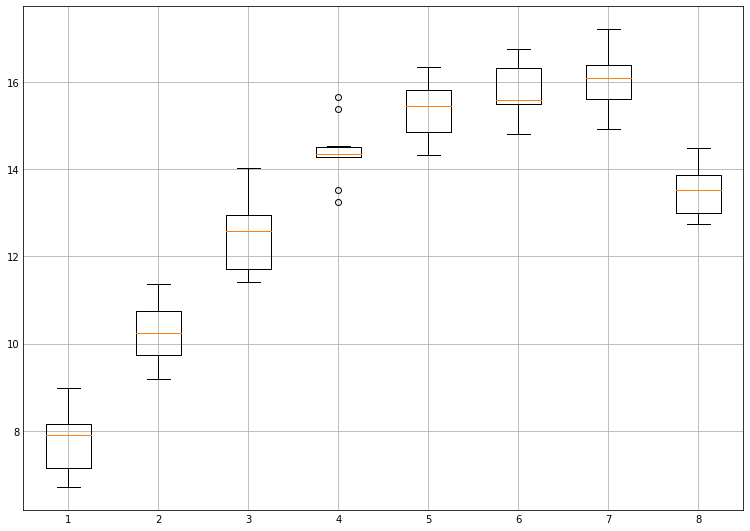

In [119]:
fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(data)
# show plot
plt.show()

In [120]:
np.array([lstmende_test_scores[11][i][2] for i in range (5)]).shape

(5, 105, 7, 1)

In [121]:
predictions = np.array([lstmende_test_scores[11][i][2] for i in range (rep)])

In [122]:
np.mean(predictions[:,0,6])

4.111451

In [123]:
predictions.shape

(10, 105, 7, 1)

In [124]:
predictions.shape[1]

105

In [125]:
np.mean(predictions[:,0,6])

4.111451

In [126]:
mean_predict = []
var_predict = []
for i in range(105):
    mean_predict.append(np.mean(predictions[:,i,6]))
    var_predict.append(np.std(predictions[:,i,6]))

In [127]:
test2= ex_R_multi[ex_R_multi['year']==years[-1]]
y= np.array(test2['chl'])
x = np.array(test2.doy)
z= np.array(mean_predict)
z1= mean_predict - np.array(var_predict)
z2= mean_predict + np.array(var_predict)

In [128]:
len(test2)

116

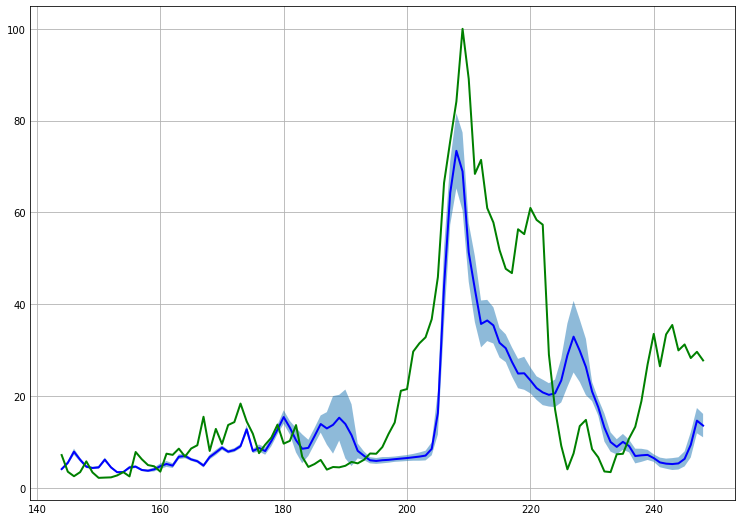

In [129]:
plt.style.use('_mpl-gallery')

# plot
fig = plt.figure(figsize =(10, 7))
start= len (test2) - predictions.shape[1]
plt.fill_between(x[11:], z1, z2, alpha=.5, linewidth=0)
plt.plot(x[11:], z, linewidth=2, color= 'blue')
plt.plot(x[11:], y[11:], linewidth=2, color= 'green')
plt.show()

### Test predictions for best cases

In [ ]:
selected= pd.DataFrame()
selected= selected.append(lstmende_test[lstmende_test['overall_score']== lstmende_test.overall_score.min()])
selected = selected.append(lstmende_test[lstmende_test['7']== lstmende_test['7'].min()])
selected = selected.append(lstmende_result[lstmende_result['overall_score']== lstmende_result['overall_score'].min()])
selected = selected.append(lstmende_result[lstmende_result['7']== lstmende_result['7'].min()])

In [34]:
dill.dump(selected, open('selected_lstmende_pet.pkd', 'wb'))
selected.to_csv('selected_lstmende_pet.csv', index=False)

In [35]:
selected

,n_input,n_nodes,n_epochs,n_batch,1,2,3,4,5,6,7,overall_score
11,7.0,512.0,50.0,16.0,7.889252,10.179857,11.681752,12.823193,13.851435,15.063272,16.549237,12.869727
3,5.0,256.0,50.0,16.0,7.327525,10.939514,13.859824,14.208024,14.793576,15.192118,15.819298,13.454841
0,5.0,200.0,50.0,1.0,10.516226,12.494204,13.636425,14.692777,15.474840,16.007251,16.514244,14.327536
0,5.0,200.0,50.0,1.0,10.516226,12.494204,13.636425,14.692777,15.474840,16.007251,16.514244,14.327536


In [36]:
selected_configs = []
for index, row in selected.iterrows():
    config = [int(row['n_input']), int(row['n_nodes']), int(row['n_epochs']), int(row['n_batch'])]
    selected_configs.append(config)

In [38]:
#Best 7 Days, Best Overall Test, Best Validation, Best 7 Days Valid
final_predics= []
iter= 1
for config in selected_configs:
    print(iter)
# final evaluate configs
    final_predics.append(final_eval_lstmende(train2, test, config)[2])
    iter+=1

1
2
3
4


In [ ]:
dill.dump(final_predics, open('lstmende_final_predics_pet.pkd', 'wb'))

In [ ]:
selected_configs

In [ ]:
test2= ex_R_multi[ex_R_multi['year']==years[-1]]
y= np.array(test2['chl'])
x = test2.doy
plt.figure(figsize=(20,7))
plt.plot(x, y, label="Actual Observations", color='Blue', linewidth=1.5)
plt.plot(x[selected_configs[0][0]+6:], final_predics[0][:,6], label="Best Overall Forecast (Test)", color='Red', linewidth=1 , linestyle='dashed')
plt.plot(x[selected_configs[1][0]+6:], final_predics[1][:,6], label="Best 7 Days Forecast (Test)", color='Green', linewidth=1 , linestyle='dashed')
plt.plot(x[selected_configs[2][0]+6:], final_predics[2][:,6], label="Best Overall Forecast (Validation)", color='purple', linewidth=1 , linestyle='dashed')
plt.plot(x[selected_configs[3][0]+6:], final_predics[3][:,6], label="Best 7 Days Forecast (Validation)", color='orange', linewidth=1 , linestyle='dashed')

#plt.plot(x[7:], y[:-7], label="Naive Forecast", color='Grey', linestyle='dashed',linewidth=1)
plt.title("7-days forecast, lake Peter, 2019", fontsize=20)
plt.xlabel('Day of Year (2019)',fontsize=20)
plt.xticks(fontsize= 16)
plt.yticks(fontsize= 16)
plt.ylabel('Algal Biomass',fontsize=20)
plt.legend(fontsize=18, loc=2)
#plt.savefig('/Volumes/GoogleDrive/My Drive/UVa/Spring2019/Presidential Fellowship/comparison paper/Figures/7-days forecast, lake Peter, 2019_slides.jpeg')
plt.show()

In [ ]:
n_input= 7
y= np.array(test['chl'])
x = test.doy
Predict_lstm= pd.DataFrame ({'doy':[], 'actual':[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[]})
Predict_lstm['doy'] = test.doy
Predict_lstm['actual'] = test.chl
for i in range (6):
    Predict_lstm[i+1].iloc[n_input+i:-6+i] = final_predics[1][:,i].reshape(100,)
Predict_lstm[7].iloc[n_input+6:] = final_predics[1][:,6].reshape(100,)
Predict_lstm.to_csv('Predict_lstm.csv', index=False)